In [1]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from __future__ import print_function

In [2]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [3]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [4]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras.optimizers

Using TensorFlow backend.


In [5]:
trDir    = '../Data/train-tif'
trDirTIF = trDir
trDirJPG = '../Data/train-jpg'
trLabels = '../Data/train.csv/train.csv'

In [6]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [8]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [9]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [12]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:3,:]

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [144]:
def formFH (nf, bins, printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                r,g,b = ni[:,:,0],ni[:,:,1],ni[:,:,2]
                rh = np.divide(np.histogram(r,bins=bins,density=False)[0],(0.0+r.size))
                gh = np.divide(np.histogram(g,bins=bins,density=False)[0],(0.0+g.size))
                bh = np.divide(np.histogram(b,bins=bins,density=False)[0],(0.0+b.size))
                nx = np.hstack((rh,gh,bh)); 
            if (ni.shape[2]==4) :
                r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,1],ni[:,:,3]
                d  = np.divide((r-n),(r+n+0.01))
                rh = np.divide(np.histogram(r,bins=bins,density=False)[0],(0.0+r.size))
                gh = np.divide(np.histogram(g,bins=bins,density=False)[0],(0.0+g.size))
                bh = np.divide(np.histogram(b,bins=bins,density=False)[0],(0.0+b.size))
                nh = np.divide(np.histogram(n,bins=bins,density=False)[0],(0.0+n.size))
                dh = np.divide(np.histogram(d,bins=bins,density=False)[0],(0.0+d.size))
                nx = np.hstack((rh,gh,bh,nh,dh)); 
    except e :
        print(nf,e); nx = None;
    
    if (nx is None) and printOK : print('------ None:',nf)
        
    return(nx)


In [149]:
trX, trY, i, size = [],[], 0, 50000
step=10; bins=[x for x in range(0,255+step,step)] # RGB -> 0..255
step=100; bins=[x for x in range(0,65535+step+1,step)] # BGRN -> 0..65535
for nn in nameList[0:size] :
    #nf = os.path.join(trDirJPG,nn+".jpg");
    nf = os.path.join(trDirTIF,nn+".tif");
    nx = formFH(nf,bins)
    if (nx is not None) :
        nx=nx.reshape(nx.shape+(1,))
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%1000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

len(trX)
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)

2017-05-08 17:09:26.806783 	 1000 	 train_999
2017-05-08 17:09:48.961334 	 2000 	 train_1999
2017-05-08 17:10:24.045246 	 3000 	 train_2999
2017-05-08 17:10:59.969919 	 4000 	 train_3999
2017-05-08 17:11:35.768478 	 5000 	 train_4999
2017-05-08 17:12:11.729487 	 6000 	 train_5999
2017-05-08 17:12:48.663146 	 7000 	 train_6999
2017-05-08 17:13:24.420594 	 8000 	 train_7999
2017-05-08 17:13:59.772336 	 9000 	 train_8999
2017-05-08 17:14:35.894553 	 10000 	 train_9999
2017-05-08 17:15:12.844613 	 11000 	 train_10999
2017-05-08 17:15:48.364166 	 12000 	 train_11999
2017-05-08 17:16:23.911035 	 13000 	 train_12999
2017-05-08 17:16:59.686980 	 14000 	 train_13999
2017-05-08 17:17:37.214424 	 15000 	 train_14999
2017-05-08 17:18:14.331001 	 16000 	 train_15999
2017-05-08 17:18:50.778861 	 17000 	 train_16999
2017-05-08 17:19:27.516917 	 18000 	 train_17999
2017-05-08 17:20:03.701861 	 19000 	 train_18999
2017-05-08 17:20:38.661111 	 20000 	 train_19999
2017-05-08 17:21:15.311156 	 21000 	 tra

In [150]:
np.save('../Data-Keras/basin02-01-X-tif.npy',trX)
np.save('../Data-Keras/basin02-01-Y-tif.npy',trY)

In [6]:
trX = np.load('../Data-Keras/basin02-01-X-tif.npy')
trY = np.load('../Data-Keras/basin02-01-Y-tif.npy')
print(trX.shape,trY.shape)

(38845, 3280, 1) (38845, 17)


In [1]:
def fbeta_pred(y_true, y_pred):
    return(fbeta_score(y_true, np.round(y_pred), beta=2, average='samples'))

In [7]:
#
#
#

ss = trX.shape[1]
rr = trY.shape[1]

model = Sequential()
#model.add(Dense(ss*10, input_shape=(ss,1))) # ?????
model.add(Dense(ss*2, input_shape=(ss,1))) # ?????
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256)) #1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128)) #1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(rr,activation='sigmoid'))
#model.add(Dropout(0.5))
#model.add(Activation('sigmoid'))
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, #"adam", #'rmsprop',
              metrics=['accuracy']) #['accuracy',fbeta_pred]) #['accuracy'])

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 3280, 6560)    13120       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 3280, 6560)    0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 3280, 6560)    0           activation_1[0][0]               
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 21516800)      0           dropout_1[0][0]                  
___________________________________________________________________________________________

In [9]:
print('time.begin :',datetime.datetime.now())
start = 0+808
steps = 64
model.fit(trX,trY,
         nb_epoch=10,
         batch_size=200,
         validation_split=0.20,
         verbose=2
         )
        #samples_per_epoch=200)
        #validation_data=validation_generator,
        #initial_epoch=start,
        #nb_val_samples=2048
         #)
print('time.end   :',datetime.datetime.now())

time.begin : 2017-05-08 18:17:59.691509
Train on 31076 samples, validate on 7769 samples
Epoch 1/10


InvalidArgumentError: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 21516800
  }
  dim {
    size: 256
  }
}
float_val: 0

	 [[Node: Const_13 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [21516800,256] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'Const_13', defined at:
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-1ebbbd0e164e>", line 8, in <module>
    verbose=2
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/keras/models.py", line 672, in fit
    initial_epoch=initial_epoch)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/keras/engine/training.py", line 1168, in fit
    self._make_train_function()
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/keras/engine/training.py", line 760, in _make_train_function
    self.total_loss)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/keras/optimizers.py", line 173, in get_updates
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 491, in zeros
    return variable(tf.constant_initializer(0., dtype=tf_dtype)(shape),
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py", line 162, in __call__
    verify_shape=self.verify_shape)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 21516800
  }
  dim {
    size: 256
  }
}
float_val: 0

	 [[Node: Const_13 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [21516800,256] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [103]:
model.save_weights('../Data-Keras/basin02-01.h5')  # save weights after training

In [105]:
print(model.evaluate(trX,trY,verbose=2))

[4.7034916280860815, 0.77781071665023205]


In [106]:
trP = model.predict(trX, batch_size=128)
print(trY.shape)
print(trP.shape)
print(fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))

(40479, 17)
(40479, 17)
0.857344153528


In [107]:
print('time.begin :',datetime.datetime.now())
print(datetime.datetime.now(),0,fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'),model.evaluate(trX,trY,verbose=2))
for i in range(30) :
    model.fit(trX,trY,
             nb_epoch=10,
             batch_size=200,
             validation_split=0.20,
             verbose=0
             )
    trP = model.predict(trX, batch_size=128)
    print(datetime.datetime.now(),i,fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'),model.evaluate(trX,trY,verbose=2))
print('time.end   :',datetime.datetime.now())

time.begin : 2017-05-08 06:01:40.489303
2017-05-08 06:01:40.489684 0 0.857344153528 [4.7034916280860815, 0.77781071665023205]
2017-05-08 06:03:15.654963 0 0.857218865491 [4.6960933575231678, 0.77672373325257715]
2017-05-08 06:04:49.644509 1 0.861230210897 [4.6773478754595299, 0.77064650804824097]
2017-05-08 06:06:23.865764 2 0.861625669256 [4.6840210499748531, 0.78364090020219734]
2017-05-08 06:07:57.945409 3 0.864851731881 [4.658351027343274, 0.75019145730473624]
2017-05-08 06:09:32.088001 4 0.866112457189 [4.637608975536482, 0.76143185355958443]
2017-05-08 06:11:06.214740 5 0.864632625479 [4.6194205410281004, 0.74613997379738506]
2017-05-08 06:12:40.304140 6 0.867292263477 [4.6092465047606126, 0.75439116579555865]
2017-05-08 06:14:14.384798 7 0.868735994721 [4.5886348807389723, 0.7617777119058875]
2017-05-08 06:15:48.462743 8 0.86981214851 [4.5849118995944504, 0.7557745991586835]
2017-05-08 06:17:22.552469 9 0.871515963808 [4.5774897673363339, 0.74967266978528169]
2017-05-08 06:18:56

In [110]:
trO = np.round(trP); trO

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]], dtype=float32)

In [111]:
trY

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [113]:
fbeta_score(trY, np.array(trO) > 0.2, beta=2, average='samples')

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.85370853521268431

In [92]:
trfiles = os.listdir(trDir); print(len(trfiles),trfiles[1]);

40479 train_16658.tif


In [93]:
imgTIF = os.path.join(trDir,trfiles[1])
imgJPG = os.path.join(trDirJPG,os.path.splitext(trfiles[1])[0]+".jpg")
img  = cv.imread(imgTIF,-1); img.shape
jpg  = cv.imread(imgJPG,-1); jpg.shape

(256, 256, 3)

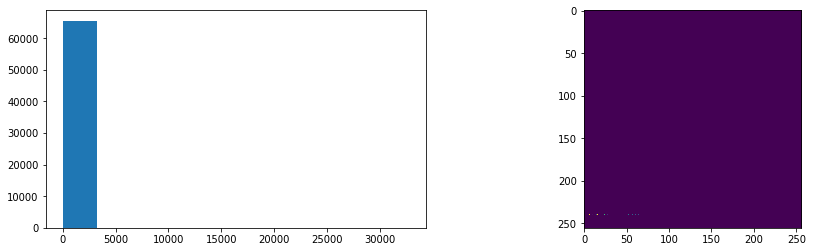

In [95]:
fig = plt.figure()
fig.set_size_inches(15, 4)
ndvi = np.divide((img[:,:,2]-img[:,:,3]),(img[:,:,2]+img[:,:,3]+1))
fig.add_subplot(121); plt.hist(ndvi.ravel());
fig.add_subplot(122); plt.imshow(ndvi); 
plt.show(); 

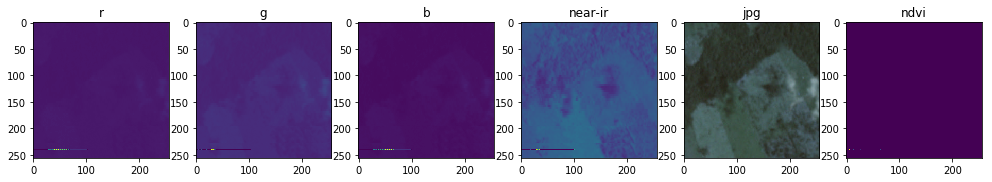

In [96]:
b,g,r,n = img[:,:,0], img[:,:,1], img[:,:,2], img[:,:,3];

fig = plt.figure();
fig.set_size_inches(17, 8);
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (n, 'near-ir'))):
    x  = x.copy().astype("float32"); x -= x.mean(); x /= x.std();
    a = fig.add_subplot(1, 6, i+1); a.set_title(c); plt.imshow(x)
a = fig.add_subplot(1, 6, 5); a.set_title("jpg"); plt.imshow(jpg); 
a = fig.add_subplot(1, 6, 6); a.set_title("ndvi"); plt.imshow(ndvi);
plt.show()


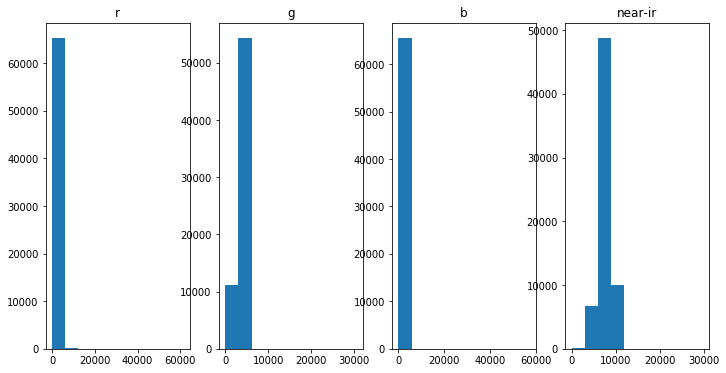

0 0 0 0
61440 57344 30575 29742
4032.98484802 2445.16603088 3586.4861145 7574.25961304
844.909376225 925.720809756 564.643057569 1385.98644852


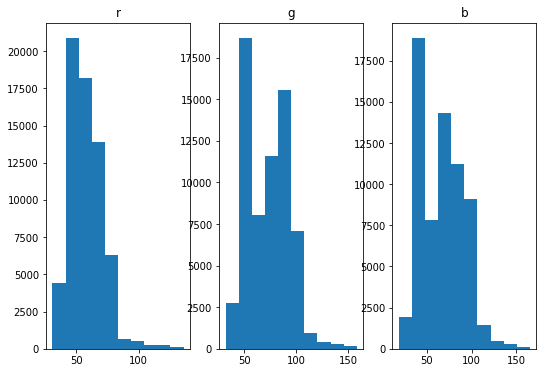

In [98]:
fig = plt.figure()
fig.set_size_inches(15, 6)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (n, 'near-ir'))):
    #x  = x.copy().astype("float32"); x -= x.mean(); x /= x.std();
    a = fig.add_subplot(1, 5, i+1); a.set_title(c); plt.hist(x.ravel())
##fig.add_subplot(1, 5, 5); plt.imshow(jpg); plt.show(); 
plt.show()
print(r.min(),b.min(),g.min(),n.min())
print(r.max(),b.max(),g.max(),n.max())
print(r.mean(),b.mean(),g.mean(),n.mean())
print(r.std(),b.std(),g.std(),n.std())

fig = plt.figure()
fig.set_size_inches(15, 6)
for i, (x, c) in enumerate(((jpg[:,:,0], 'r'), (jpg[:,:,1], 'g'), (jpg[:,:,2], 'b'))) :
    #x  = x.copy().astype("float32"); x -= x.mean(); x /= x.std();
    a = fig.add_subplot(1, 5, i+1); a.set_title(c); plt.hist(x.ravel())
##fig.add_subplot(1, 5, 5); plt.imshow(jpg); plt.show(); 
plt.show()

